In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import string
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import itertools
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler

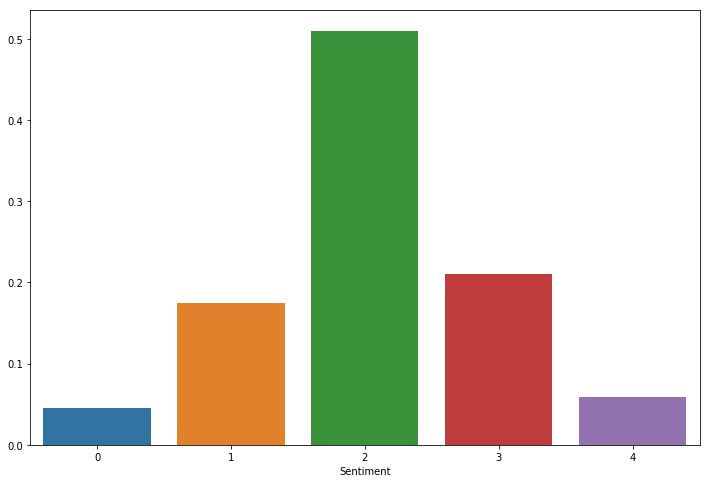

In [3]:
class SentimentAnalysis(object):
   
    def __init__(self,train, test):
        self.train=train
        self.test=test
        self.logreg=LogisticRegression( 
                            dual=False, tol=0.0001,fit_intercept=True, intercept_scaling=1, 
                            class_weight=None, random_state=None,
                            solver='newton-cg',multi_class='multinomial', verbose=0, 
                            warm_start=False, n_jobs=None)
               
        self.countvectorizer=CountVectorizer(
                                    input='content',
                                    encoding='utf-8',
                                    decode_error='strict',
                                    strip_accents=None,
                                    lowercase=True,
                                    preprocessor=None,
                                    tokenizer=None,
                                    stop_words=None,
                                    token_pattern=r"(?u)\b\w\w+\b",
                                    ngram_range=(1,2),
                                    analyzer='word',
                                    max_df=1.0,
                                    min_df=1,
                                    max_features=None,
                                    vocabulary=None,
                                    binary=False,
                                    dtype=np.float64
                                    )
        
        self.xgboost = XGBClassifier(
                       booster='gbtree', colsample_bylevel=1,base_score=0.5,learning_rate=0.5,
                       colsample_bytree=1, gamma=0, max_delta_step=0,
                       max_depth=8, min_child_weight=1, missing=None, 
                       n_jobs=1, nthread=4, objective='multi:softmax',num_class=5, random_state=0,
                       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                       silent=True, subsample=1)
        
        self.naive = MultinomialNB()
    
    def featuring(self):
        merge=pd.concat([self.train.iloc[:,0:3],self.test.iloc[:,0:3]],  sort = False)
        df=merge.reset_index(drop=True)
        corpus=merge.Phrase
        COMMENT = 'Phrase'
        df['total_length'] = df[COMMENT].apply(len)

        df['words'] = df[COMMENT].apply(lambda comment: len(comment.split()))
        df['words_vs_length'] = df['words'] / df['total_length']

        df['capitals'] = df[COMMENT].apply(lambda comment: sum(1 for c in comment if c.isupper()))
        df['capitals_vs_length'] = df['capitals'] / df['total_length']


        df['paragraphs'] = df[COMMENT].apply(lambda comment: comment.count('\n'))
        df['paragraphs_vs_length'] = df['paragraphs'] / df['total_length']


        eng_stopwords = set(stopwords.words("english"))
        df['stopwords'] = df[COMMENT].apply(lambda comment: sum(comment.count(w) for w in eng_stopwords))
        df['stopwords_vs_length'] = df['stopwords'] / df['total_length']


        df['exclamation_marks'] = df[COMMENT].apply(lambda comment: comment.count('!'))
        df['exclamation_marks_vs_length'] = df['exclamation_marks'] / df['total_length']


        df['question_marks'] = df[COMMENT].apply(lambda comment: comment.count('?'))
        df['question_marks_vs_length'] = df['question_marks'] / df['total_length']


        df['unique_words'] = df[COMMENT].apply(
            lambda comment: len(set(w for w in comment.split())))
        df['unique_words_vs_length'] = df['unique_words'] / df['total_length']


        import collections

        repeated_threshold = 15
        def count_repeated(text):
            text_splitted = text.split()
            word_counts = collections.Counter(text_splitted)
            return sum(count for word, count in sorted(word_counts.items()) if count > repeated_threshold)



        df['repeated_words'] = df[COMMENT].apply(lambda comment: count_repeated(comment))
        df['repeated_words_vs_length'] = df['repeated_words'] / df['total_length']


        def tag_part_of_speech(text):
            text_splited = text.split(' ')
            text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
            text_splited = [s for s in text_splited if s]
            pos_list = pos_tag(text_splited)
            noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
            adjective_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
            verb_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
            return[noun_count, adjective_count, verb_count]

        nltk.download('averaged_perceptron_tagger')

        df['nouns'], df['adjectives'], df['verbs'] = zip(*df[COMMENT].apply(
            lambda comment: tag_part_of_speech(comment)))

        df['nouns_vs_length'] = df['nouns'] / df['total_length']
        df['adjectives_vs_length'] = df['adjectives'] / df['total_length']
        df['verbs_vs_length'] = df['verbs'] / df['total_length']
        #Scaling the features
        num_features = [f_ for f_ in df.columns
                if f_ not in ["Phrase", "PhraseId","SentenceId"]]

        type(num_features)
        print(num_features)
        skl = MinMaxScaler()
        df_num_features = skl.fit_transform(df[num_features])
        print(df_num_features.shape)
        #Separating train, test data
        self.train_num_features = df_num_features[:train.shape[0]]
        self.test_submit_num_features = df_num_features[train.shape[0]:]

        
    def countvect(self):
        self.train['Phrase'] = self.train['Phrase'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex = True)
        self.test['Phrase'] = self.test['Phrase'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex = True)
        self.train_vect = self.countvectorizer.fit_transform(train['Phrase'])
        self.test_vect = self.countvectorizer.transform(test['Phrase'])
        self.X_train = hstack([self.train_vect, self.train_num_features])
        self.X_test_submit = hstack([self.test_vect, self.test_submit_num_features])

        
    def trainLogistic(self):
        grid={"C":[1.0], "max_iter":[100]}
        self.GridSe1 = GridSearchCV(self.logreg , grid, cv=25)
        self.GridSe1.fit(self.X_train, self.train['Sentiment'])
        print("tuned hpyerparameters :(best parameters) ",self.GridSe1.best_params_)
        print("accuracy :",self.GridSe1.best_score_)
        LogRegGrid_path = 'LogRegGrid.pkl'
        # Create an variable to pickle and open it in write mode
        LogRegGrid_pickle = open(LogRegGrid_path, 'wb')
        pickle.dump(self.GridSe1, LogRegGrid_pickle)
        LogRegGrid_pickle.close()

    def testLogistic(self):
        self.pred1=self.GridSe1.predict(self.X_test_submit)
        first_sub=self.test.copy()
        n=first_sub.shape[0]
        first_sub["Sentiment"] = self.pred1
        first_sub = first_sub.loc[:, ["PhraseId", "Sentiment"]]
        first_sub.to_csv("logistic.csv", index=False)
        
    def trainxgboost(self):
        grid={"n_estimators":[1000]}
        self.GridSe2 = GridSearchCV(self.xgboost , grid, cv=25)
        self.GridSe2.fit(self.X_train, self.train['Sentiment'])
        print("tuned hpyerparameters :(best parameters) ",self.GridSe2.best_params_)
        print("accuracy :",self.GridSe2.best_score_)
        XGBoost_path = 'XgBoost.pkl'
        # Create an variable to pickle and open it in write mode
        XGBoost_pickle = open(XGBoost_path, 'wb')
        pickle.dump(self.GridSe2, XGBoost_pickle)
        XGBoost_pickle.close()
        
    def testxgboost(self):
        self.pred2=self.GridSe2.predict(self.X_test_submit)
        first_sub=self.test.copy()
        n=first_sub.shape[0]
        first_sub["Sentiment"] = self.pred2
        first_sub = first_sub.loc[:, ["PhraseId", "Sentiment"]]
        first_sub.to_csv("xgboost.csv", index=False)
        
        
    def trainnaive(self):
        grid={"alpha":[0.001]}
        self.GridSe3 = GridSearchCV(self.naive , grid, cv=25)
        self.GridSe3.fit(self.X_train, self.train['Sentiment'])
        print("tuned hpyerparameters :(best parameters) ",self.GridSe3.best_params_)
        print("accuracy :",self.GridSe3.best_score_)
        NaiveBayes_path = 'MultinomialNB.pkl'
        # Create an variable to pickle and open it in write mode
        NaiveBayes_pickle = open(NaiveBayes_path, 'wb')
        pickle.dump(self.GridSe3, NaiveBayes_pickle)
        NaiveBayes_pickle.close()
        
    def testnaive(self):
        self.pred3=self.GridSe3.predict(self.X_test_submit)
        first_sub=self.test.copy()
        n=first_sub.shape[0]
        first_sub["Sentiment"] = self.pred3
        first_sub = first_sub.loc[:, ["PhraseId", "Sentiment"]]
        first_sub.to_csv("NaiveBayes.csv", index=False)
        
        
    def visualize(self):
        dist = self.train.groupby(["Sentiment"]).size()
        dist = dist / dist.sum()
        fig, ax = plt.subplots(figsize=(12,8))
        sns.barplot(dist.keys(), dist.values);
        
if __name__ == "__main__":
    train = pd.read_csv("train.csv")
    test  = pd.read_csv("test.csv")
    model=SentimentAnalysis(train,test)
    model.visualize()
    model.featuring()
    model.countvect()
    
    #LogisticRegression
    model.trainLogistic()
    model.testLogistic()
    
    #XG Boost
    model.trainxgboost()
    model.testxgboost()
    
    #Multinomial NaiveBayes
    model.trainnaive()
    model.testnaive()
    
       